# **See full article on [Meduim](https://medium.com/@tharindumadhusanka99/llama3-rag-on-google-colab-73c43aa53281)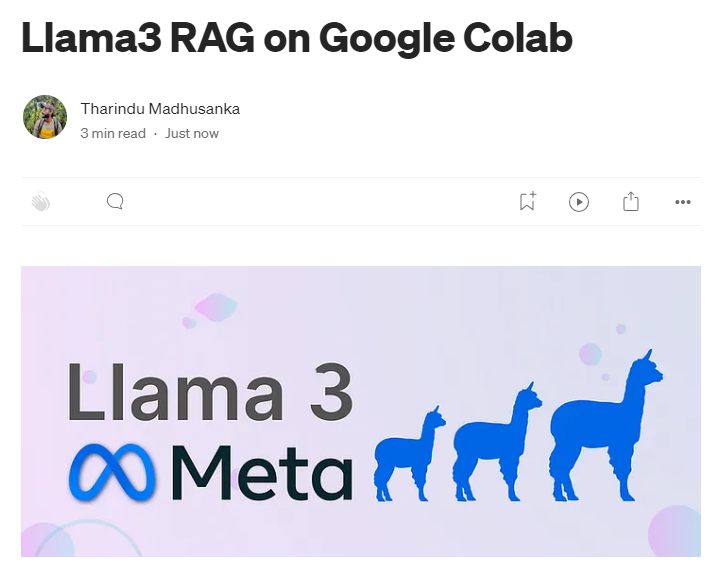**

In [1]:
# %load_ext colabxterm

In [2]:
# type these two lines of codes in below terminal after run the cell (%xterm):
# curl -fsSL https://ollama.com/install.sh | sh
# ollama serve & ollama pull llama3 & ollama pull nomic-embed-text

In [3]:
# %xterm

In [4]:
# !pip -qq install langchain
# !pip -qq install langchain-core
# !pip -qq install langchain-community

In [5]:
#Lendo do arquivo salvo...
from tqdm import tqdm
import pandas as pd
import numpy as np
np.float_ = np.float64
data = pd.read_csv('EIOS_train.csv')
train = pd.DataFrame(data)
data = pd.read_csv('EIOS_test.csv')
test = pd.DataFrame(data)
print(train.label.value_counts())

label
Arboviroses                                               1287
Doenças Respiratórias                                     1093
Vigilância dos Desastres                                  1050
Zoonoses                                                   635
Vigilância dos Acidentes e Violências                      471
Assistência                                                455
Infecções Sexualmente Transmissíveis (IST)                 350
Imunização                                                 310
Imunoprevenível                                            249
Evento de Saúde Pública (ESP)                              209
Vigilância Animal                                          206
Doença Crônica Não Transmissível (DCNT)                    185
Doenças de Transmissão Hídrica e Alimentar (DTHA)          156
Doença Crônica Transmissível (DCT)                         133
Alusivo/ Informativo                                        94
Meningites                                       

In [6]:
from langchain_community.llms import Ollama
llm = Ollama(model = "llama3.1")

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [7]:
llm.invoke("what is the Meaning of life")

"The question of the meaning of life has puzzled philosophers, theologians, scientists, and everyday humans for centuries. There's no one definitive answer, as it depends on individual perspectives, cultural contexts, and personal experiences. Here are some possible interpretations:\n\n**Philosophical perspectives:**\n\n1. **Existentialism**: Life has no inherent meaning; we must create our own purpose through choices and actions.\n2. **Humanism**: The meaning of life is to seek happiness, fulfillment, and self-actualization.\n3. **Essentialism**: Life has a fixed essence or nature that gives it meaning (e.g., fulfilling one's potential, achieving spiritual enlightenment).\n\n**Religious perspectives:**\n\n1. **Christianity**: The meaning of life is to love God and follow His will, ensuring salvation and eternal life with Him.\n2. **Buddhism**: Life has no inherent meaning; our purpose is to escape suffering (dukkha) and attain enlightenment.\n3. **Hinduism**: The meaning of life is to

In [8]:
# prompt = "Classifique o texto do campo Questão: em uma das seguintes classes com relação ao contexto da área da saúde: 1) Relevante ou 2) Irrelevante, apenas as palavras 'Relevante' ou 'Irrelevante' devem ser utilizadas para a classe. A resposta deve vir com uma justificativa para a classe informada. A saída deve ser padronizada no formato de um dicionário em python como segue: {classe: Relevante ou Irrelevante para o contexto da área da saúde, justificativa: texto com a justificativa da classe}. por exemplo, para questão: 'tenho dores pulmonares afetadas pelo cigarro' a saida deve ser formatada como segue {'classe':'Relevante', 'justificativa':'Texto trata de um problema respiratório relacionado a área da saúde'}."
# #response = llm.invoke(prompt+"Questão: hoje eu acordei com dores na gargante como minha filha também.")
# response = llm.invoke(prompt+"Questão: minha rua está cheia de buracos.")
# print(response)

In [9]:
# #convert string into dictionary
# import ast
# dictio = ast.literal_eval(response)
# print(dictio)
# print(dictio['classe'])

In [10]:
# !pip install ollama langchain beautifulsoup4 chromadb gradio -q

In [11]:
# !pip install chromadb

In [ ]:
import gradio as gr
import ollama
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.document_loaders import DataFrameLoader

# Load the data from pandas
loader = DataFrameLoader(test, page_content_column="text") #usando o test por ser pequeno
docs = loader.load()
# print(docs)

# Split the loaded documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Create Ollama embeddings and vector store
embeddings = OllamaEmbeddings(model="nomic-embed-text")
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)

In [31]:

# Define the function to call the Ollama Llama3 model
def ollama_llm(question, context):

    # prompt_specs = "Classifique o texto do campo Questão: em uma das seguintes classes com relação ao contexto da área da saúde: 1) Relevante ou 2) Irrelevante, apenas as palavras 'Relevante' ou 'Irrelevante' devem ser utilizadas para a classe. A resposta deve vir com uma justificativa para a classe informada. A saída deve ser padronizada no formato de um dicionário em python como segue: {'classe': 'Relevante ou Irrelevante para o contexto da área da saúde', 'justificativa': 'texto com a justificativa da classe'}. por exemplo, para questão: 'tenho dores pulmonares afetadas pelo cigarro' a saida deve ser formatada como segue {'classe':'Relevante', 'justificativa':'Texto trata de um problema respiratório relacionado a área da saúde'}"

    prompt_specs = """
        Classifique se as questões são relevantes ou irrelevantes para o contexto da área de saúde.
        Pense da perspectiva de um profissional de saúde que está avaliando a importância das questões para o cuidado ao paciente.

        Você deve classificar cada questão em uma das 2 categorias:
        1. Relevante
        2. Irrelevante

        Para cada questão, forneça uma justificativa detalhada para a escolha feita.
        Certifique-se de que a justificativa seja clara e esteja relacionada ao contexto da área da saúde.

        Faça:
        1. Seja específico e claro.
        2. Compreenda o contexto da questão relacionada à saúde antes de categorizá-la.
        3. Aja como um profissional de saúde.

        NÃO faça:
        1. Não adivinhe ou invente informações.
        2. Não crie novas categorias de justificativa; utilize apenas as fornecidas acima.

        Dica: Classifique como irrelevante quaisquer questões que não estejam diretamente relacionadas à saúde ou cuidados médicos.

        O formato de saída deve ser o seguinte:
        {
            "classe": "",
            "justificativa": ""
        }

        A classe deve ser uma string das categorias acima: 'Relevante' ou 'Irrelevante'.
        A justificativa deve ser um texto explicando o motivo da escolha da categoria.

        Exemplos:
        1. Questão: 'Tenho dores pulmonares afetadas pelo cigarro.'
            Saída: { 'classe': 'Relevante', 'justificativa': 'O texto trata de um problema respiratório diretamente relacionado à área da saúde.' }

        2. Questão: 'Como posso aumentar minha produtividade no trabalho?'
            Saída: { 'classe': 'Irrelevante', 'justificativa': 'A questão não está relacionada diretamente ao contexto da área da saúde.' }

        3. Questão: 'Tenho dores nas costas após longas horas sentado.'
            Saída: { 'classe': 'Relevante', 'justificativa': 'A questão aborda um problema de saúde ocupacional que afeta a coluna vertebral.' }

        4. Questão: 'Quais são os melhores livros de autoajuda?'
            Saída: { 'classe': 'Irrelevante', 'justificativa': 'A questão não se relaciona diretamente com o contexto de saúde ou cuidados médicos.' }
        
        Não se esqueça das orientações e forneça a resposta no formato de saída indicado.

        A saída deve ser estritamente no formato indicado, com aspas simples e chaves.

        A classificação deve ser exclusivamente entre 'Relevante' e 'Irrelevante'.
    """
    
    formatted_prompt = f"{prompt_specs}\nQuestão: {question}\n\nContexto: {context}"
    response = ollama.chat(model='llama3.1', messages=[{'role': 'user', 'content': formatted_prompt}])
    return response['message']['content']

# Define the RAG setup
#retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 100}) #Variar esse K para encontrar a quantidade ideal
retriever = vectorstore.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": 1.5}) #variar o score do trheshold
def rag_chain(question):
    retrieved_docs = retriever.invoke(question)
    formatted_context = "\n\n".join(doc.page_content for doc in retrieved_docs)
    return ollama_llm(question, formatted_context)

# Define the Gradio interface
def get_important_facts(question):
    return rag_chain(question)

In [33]:
import ast
# response = rag_chain("a minha vizinha estar com dor nos olhos após lavar com agua corrente da torneira.")

question = """
    Tida como principal legado da gestão de Carlos Arthur Nuzman à frente do COB (Comitê Olímpico do Brasil), a Lei Piva financiou as entidades esportivas e as tornou dependentes de seus recursos, que são públicos.  Levantamento feito pela Folha indica que 10 das 30 confederações esportivas olímpicas nacionais tiveram o exercício de 2017 totalmente custeado com verba da lei.  Destas, sete afirmaram não ter outra fonte de renda senão os aportes oriundos da norma, sancionada em julho de 2001 após pesado lobby de Carlos Artur Nuzman no Congresso Nacional.  A legislação instituiu que 1,7% da arrecadação bruta das loterias federais vai para o COB. O CPB (Comitê Paraolímpico Brasileiro) recebe 1% da receita com jogos de azar.  Para 2017, por exemplo, o COB trabalhava com estimativa de R$ 210 milhões, dos quais R$ 85 milhões seriam dirigidos às confederações. A gestão do repasse desse dinheiro é do comitê.  Nos 16 anos entre a sua criação e a última quinta (5), quando Nuzman foi preso temporariamente pela Polícia Federal por suposta participação na compra de votos para eleger o Rio sede dos Jogos de 2016, a Lei Piva ajudou a consolidar o domínio de poder do cartola dentro do COB.  Nuzman instituiu salários a presidentes de confederações -e ainda a diretores delas- com recursos da lei, por exemplo. Ao longo dos anos, o esporte olímpico nacional ficou cada vez mais "pivadependente" e as confederações, com cada vez menos autonomia.  DINHEIRO PÚBLICO  Entre as 29 confederações consultadas, levantamento de peso, esgrima, boxe, pentatlo moderno, ciclismo remo e hóquei sobre a grama disseram que suas receitas vêm 100% de verba pública.  Vale um parêntese. Apenas boxe, com ouro nos Jogos do Rio-2016, e o pentatlo moderno, com um bronze em Londres-2012, foram ao pódio nas últimas duas Olimpíadas.  Outras sete -triatlo, vela, tênis de mesa, desportos no gelo, wrestling, badminton e tiro esportivo- contaram com dinheiro da Lei Piva para compor 50% ou mais do orçamento para este ano.  Somente o rúgbi disse que a fatia advinda da lei representa menos de 20% de seus ganhos -o vôlei não deu detalhes da divisão. Confederações de canoagem, basquete, hipismo e tiro com arco não responderam à reportagem.  "Sem os recursos da Lei Piva, a CBHG não teria condições de continuar funcionando", disse a confederação de hóquei sobre a grama.  A modalidade foi a única que deixou de levar equipe para os Jogos do Rio. A equipe feminina nacional, por não figurar nem ao menos entre as 40 primeiras do ranking mundial, não pôde competir.  Durval Balen, líder do tiro esportivo nacional, que obteve uma medalha de prata com Felipe Wu na Rio-2016, afirmou que a entidade "jamais teve patrocínio, seja de empresas públicas ou privadas".  "Ter recursos da Lei Piva é vital para a confederação manter as suas atividades. Sem estes, estaria inviabilizado, por exemplo, o trabalho de preparação dos nossos atletas das disciplinas olímpicas e pagamento dos salários de treinadores", disse.  Devido a problemas de Justiça ou de prestações de contas, o taekwondo, os esportes aquáticos e o basquete tiveram recursos da Lei Piva bloqueados nesta temporada.  Por causa das restrições, o COB tem ajudado diretamente na preparação dos atletas das respectivas entidades.  De 2016 para 2017, o COB mudou seu modelo de distribuição de verbas da lei. Criou um sistema de pontos e fez cortes nos repasses. O que desagradou as confederações mais dependentes dela.  "[Sem recursos] Seria impossível realizar as operações. Com o corte de recursos neste ano, a CBTM teve de diminuir em quase 50% o quadro de funcionários", diz a confederação de tênis de mesa.  Os valores previstos pela norma são repassados pela Caixa Econômica Federal.  Consultado, o banco disse que o suposto envolvimento de Nuzman no esquema de compra de votos não vai atingir os pagamentos.  "Os repasses de recursos das loterias federais às instituições beneficiárias são executados em estrito cumprimento à legislação vigente, não constituindo prerrogativa desta empresa pública atuação diversa da prevista em lei", assinalou a estatal.  RISCO  Tramitam no Congresso alguns projetos de lei que pedem alterações na Lei Piva. Uma delas é do deputado federal Ezequiel Texeira (PTN-RJ), que queria estabelecer teto para utilização dos recursos vindos da arrecadação na manutenção burocrática do COB, CPB e confederações.  Outras visam tirar dos comitês olímpicos e paraolímpicos a responsabilidade de operar os repasses. "Se cortar a Lei Piva, o esporte nacional de alto rendimento para", afirmou o presidente da confederação de vela, Marco Aurélio de Sá Ribeiro.  "No futuro, eu acho que todas as confederações têm que fazer o dever de casa e ir atrás de outros recursos. Minha ideia é que a Lei Piva caia para 20% dos meus recursos em 2020", complementou.  A vela brasileira tem 59% de suas receitas bancadas pelo dinheiro da Lei Piva e outros 41% de patrocinadores.  "A lei é muito boa por um lado, mas por outro pôs as confederações como agência pegadoras de dinheiro público", finalizou o dirigente.
"""

response = rag_chain(question)
print(response)

/home/geffte/.local/lib/python3.10/site-packages/langchain_core/vectorstores/base.py:559: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'Unnamed: 0': 5100, 'label': 'Vigilância Animal'}, page_content='Recebeu sanção da governadoria e está no Diário Oficial de Goiás, a Lei Estadual nº 22.101, originalmente projeto de lei nº 5030/21, de autoria do presidente da Alego, deputado Bruno Peixoto (UB).A referida lei institui, no âmbito do estado, a Campanha de Conscientização sobre a Castração de Cães e Gatos.Conforme aponta a redação, a campanha visa a promoção de ações educativas para a conscientização da população sobre a importância e os benefícios da castração para a saúde dos animais.“Além da contenção de zoonoses e da inibição de instintos de demarcação de território e fugas, a castração contribui principalmente para o controle de natalidade e de doenças como o câncer. Diminuindo os nascimentos não planejados, teremos menos cães e gatos abandonados em s

O texto apresenta a situação financeira das confederações esportivas brasileiras e sua dependência dos recursos provenientes da Lei Piva (Lei do Esporte). A reportagem destaca que apenas boxe, pentatlo moderno, canoagem, basquete e hipismo não são dependentes de mais de 20% dos orçamentos anuais. As demais confederações dependem em algum grau da Lei Piva para manter suas atividades.

A Lei Piva é fundamental para a continuidade das confederações, pois fornece os recursos necessários para realizar as operações diárias, como pagamento de funcionários e treinadores. A falta desses recursos pode comprometer as competições e até mesmo o trabalho de preparação dos atletas.

A reportagem também menciona que algumas confederações tiveram problemas com a Lei Piva em decorrência de problemas de Justiça ou prestações de contas, sendo bloqueados os seus recursos. Como resultado, essas confederações precisaram recorrer ao COB (Comitê Olímpico Brasileiro) para obter ajuda financeira.

Além disso, a 

In [15]:
#convert string into dictionary
dictio = ast.literal_eval(response)

In [16]:
def redimensionar_df(df, n):
    data_test = []

    for _, row in df.iterrows():
        data_test.append(row['text'])
        if len(data_test) == n:
            break

    df_data_test = pd.DataFrame(data_test, columns=['text'])
    return df_data_test

In [17]:
df_wrongs = pd.read_excel('wrongs.ods')
df_wrongs = redimensionar_df(df_wrongs, 200)
df_test = redimensionar_df(train, 200)

In [18]:
print(len(df_wrongs),len(df_test))

200 200


In [19]:
def run_test(df):
    correct = 0
    for text in tqdm(df['text']):
        response = rag_chain(text)
        response = ast.literal_eval(response)
        choice = response['classe'].lower()
        if choice == 'relevante':
            correct += 1
    return correct

In [20]:
correct_test = run_test(df_test)

 23%|██▎       | 46/200 [06:07<17:33,  6.84s/it]/home/geffte/.local/lib/python3.10/site-packages/langchain_core/vectorstores/base.py:559: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'Unnamed: 0': 3146, 'label': 'Arboviroses'}, page_content='Os casos de dengue aumentaram 20% em um ano em Mato Grosso. Segundo a Secretaria de Estado de Saúde (SES-MT), as mortes subiram de 15 para 18 entre 2021 e 2022. Em 2022 foram registrados um total de 31.512 casos no Estado, um aumento de 11.247 casos comparados com 2021, que registrou 20.265 casos.'), -145.53728502037112), (Document(metadata={'Unnamed: 0': 8194, 'label': 'Arboviroses'}, page_content='O Brasil ultrapassou os 2,5 milhões de casos de dengue nesta segunda-feira (1º). Nos primeiros três meses do ano, o número de mortes chegou a 923 e ameaça bater o recorde de 2022'), -147.26951105327478), (Document(metadata={'Unnamed: 0': 1390, 'label': 'Arboviroses'}, page_content='Em meio ao recente aumento no número 

In [21]:
print(f"Correct: {correct_test}/{len(df_test)}")
print(f"Accuracy: {correct_test/len(df_test)}")

Correct: 180/200
Accuracy: 0.9


In [28]:
corrects_wrongs = run_test(df_wrongs)

  0%|          | 0/200 [00:00<?, ?it/s]/home/geffte/.local/lib/python3.10/site-packages/langchain_core/vectorstores/base.py:559: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'Unnamed: 0': 91, 'label': 'Doenças Respiratórias'}, page_content='Governo permite a partir desta quarta-feira viagens não essenciais de e para Brasil. A medida vigora até às 23h59 de dia 16 de setembro, apesar de poder ser revista “em qualquer altura, em função da evolução da situação epidemiológica”. Além disso, também os passageiros provenientes do Reino Unido deixam de estar sujeitos a quarentena à chegada a Portugal.'), -185.7690886308623), (Document(metadata={'Unnamed: 0': 4201, 'label': 'Vigilância dos Acidentes e Violências'}, page_content='Um novo tiroteio na Sérvia deixou oito mortos e 14 feridos na noite dessa quinta-feira (4). O suspeito pelo ataque foi preso na manhã desta sexta-feira (5) após muitas horas de perseguição. O novo episódio violento ocorre em um país já 

SyntaxError: invalid syntax (<unknown>, line 1)

In [29]:
print(f"Correct: {corrects_wrongs}/{len(df_wrongs)}")
print(f"Accuracy: {corrects_wrongs/len(df_wrongs)}")

NameError: name 'corrects_wrongs' is not defined

# Interface 

In [ ]:

# Create a Gradio app interface
iface = gr.Interface(
  fn=get_important_facts,
  inputs=gr.Textbox(lines=2, placeholder="Enter your question here..."),
  outputs="text",
  title="RAG with Llama3",
  description="Ask questions about the proveded context",
)

# Launch the Gradio app
iface.launch(share=True)
